<a href="https://colab.research.google.com/github/SoniaLei/nlp-web-scrapping/blob/development/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 #### This is a word2vec notebook for word2vec model to represent distributed representations of words in a corpus C.


In this model ,given a set of sentence, there are 2 approaches to this algorithim, namely:

1) **Skip-Gram** : the model loops on the words of each sentence and tries to use the current word to predict its neighbours context

2) **Continuous Bag Of Words**: uses each of the contexts to predict the current
![alt text](https://miro.medium.com/max/1114/1*99ewFdV861rqY_K14bc69w.png)

Word2vec is like an autoencoder, encoding each word and train againsts other words that neightbour them in the input corpus.


In situation where the feature vector assigned to a word cannot be used accurately predict word's context, the components of the vector are adjusted.

To limit the number of words in each content, a parameter "window size" is used.

**Model overview**
1. Creating a vocabulary of all the words in text and then to encode word as a vector of the same dimensionsof the vocabulary.
2. Each dimension can be thought as a word in the vocabulary.
3. Resulting a vector with all 0s and 1s representing the corresponding word in the vocabulary. (technique name as one-hot encoding)

Skip-gram model creates a hot-vector for each word. 
A hot vector is a vector representation of a word where the vector is the size of the vocabulary (total unique words)

---





### First of all we need to generate training data:

In [0]:
import re
import numpy as npy

def tokenize(text):
  pattern = re.compile(r'[A-za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
  return pattern.findall(text.lower())

def mapping(tokens):
  word_to_id= dict()
  id_to_word = dict()
  for i, token in enumerate(set(tokens)):
    word_to_id[token] = i
    id_to_word[i] = token

  return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
  N = len(tokens)
  X, Y = [], []

  for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])

  X = npy.array(X)
  X = npy.expand_dims(X, axis=0)
  Y = npy.array(Y)
  Y = npy.expand_dims(Y, axis=0)
  return X,Y

corpus = "After the deduction of the cost of investing," \
        "beating the stock market is a loser's game."

tokens = tokenize(corpus)
word_to_id, id_to_word = mapping(tokens)

X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]

Y_one_hot = npy.zeros((vocab_size,m))
Y_one_hot[Y.flatten(), npy.arange(m)] = 1
Y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Steps to train word2vec model** :
1. Initializing weights (introducting parameters that we want to train)
2. Propagating forward
3. Calculating the cost
4. Propagaing backward
5. Updating the weights

**Initializing weights** : There are 2 layers in the model that needs to be initialised and trained (word embedding layer and dense layer)

We want to use a matrix as a shape of the word embeding (vocab_size, emb_size). Because in this way, we can then represent all the vocabularies with **each row representing a word**

The shape of the dense layer will be similar manner, but as a **matrix multiplication**. 
* Its input will be : (emb_size , # of training instances)
* Its output to be : (vocab, # of training instances)

For each word, we want to calculate what the probability that word appears within the context of the given input word.

In [0]:
def initialize_wrd_emb(vocab_size, emb_size):
    WRD_EMB = npy.random.randn(vocab_size, emb_size) * 0.01
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    return WRD_EMB

def initialize_dense_layer(input_size, output_size):
    W = npy.random.randn(output_size, input_size) * 0.01
    assert(W.shape == (output_size, input_size))
    return W

def initialize_parameters(vocab_size, emb_size):
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense_layer(emb_size, vocab_size)

    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    return parameters

## Forward Propagation

In [0]:
def ind_to_word_vecs(inds, parameters):
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    assert(word_vec.shape ==(WRD_EMB.shape[1],m))
    return word_vec

def linear_dense(word_vec, parameters):
    m = word_vec.shape[1]
    W = parameters['W']
    Z = npy.dot(W, word_vec)
    assert(Z.shape == (W.shape[0],m))
    return W,Z

def softmax(Z):
    softmax_output = npy.divide(npy.exp(Z), npy.sum(npy.exp(Z),axis=0, keepdims=True) + 0.001)
    assert(softmax_output.shape == Z.shape)
    return softmax_output

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds,parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_output = softmax(Z)

    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z

    return softmax_output, caches

#### **Computation of the Cost(L)** using the following formula: 
 ![alt text](https://miro.medium.com/max/233/1*hMXG01hWWU0QAASsUOsPbA.png)

In [0]:
def cross_entropy(softmax_out, Y):
  m = softmax_out.shape[1]
  cost = -(1/m)*npy.sum(npy.sum(Y*npy.log(softmax_out +0.001),
                                axis=0, keepdims=True), axis =1)
  return cost

#### **Back Propagation**

This is a process to calculate graidents of the trainable weights with respect to the loss function and update the weight with its associated gradient.
This process uses **Chain Rule** in Calculus:

![alt text](https://miro.medium.com/max/106/1*XNf0iIOFu0SKOWnWQKquXg.png)

We need to apply this function to all the dense layers and word embedding layers in the matrix that we would like to train. Hence:

![alt text](https://miro.medium.com/max/217/1*YReZZYTlRC07ZVDlMi90Jw.png)

![alt text](https://miro.medium.com/max/686/1*6B8d4lwqaPRsmWHNDl0Efw.png)

![alt text](https://miro.medium.com/max/806/1*P7sM_vmmkpdtwgk90mi7wQ.png)

In [0]:
def softmax_back_propagation(Y, softmax_out):
  dL_dZ = softmax_out-Y
  assert(dL_dZ.shape == softmax_out.shape)
  return dL_dZ

def dense_layer_back_propagation(dL_dZ, caches):
  W = caches['W']
  word_vec = caches['word_vec']
  m = word_vec.shape[1]

  dL_dW = (1/m) * npy.dot(dL_dZ, word_vec.T)
  dL_dword_vec = npy.dot(W.T, dL_dZ)

  assert(W.shape == dL_dW.shape)
  assert(word_vec.shape == dL_dword_vec.shape)
  return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
  dL_dZ = softmax_back_propagation(Y, softmax_out)
  dL_dW, dL_dword_vec = dense_layer_back_propagation(dL_dZ, caches)

  gradients = dict()
  gradients['dL_dZ'] = dL_dZ
  gradients['dL_dW'] = dL_dW
  gradients['dL_dword_vec'] = dL_dword_vec

  return gradients

#### Updating parameters base on the backwawrd propagation


In [0]:
def update_parameters(parameters, caches, gradients, learning_rate):
  vocab_size, emb_size = parameters['WRD_EMB'].shape
  inds = caches['inds']
  WRD_EMB = parameters['WRD_EMB']
  dL_dword_vec = gradients['dL_dword_vec']
  m = inds.shape[-1]

  parameters['WRD_EMB'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate
  parameters['W'] -= learning_rate * gradients['dL_dW']

### Model Training

Repeating the process of forward propagation, backward propagation and weight updating to train the model.
*Note: The cost after each epoch should show a decreasing trend

In [0]:
from datetime import datetime
import matplotlib.pyplot as plt

def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256,
                            parameters=None, print_cost=False, plot_cost=True):
  costs = []
  m = X.shape[1]

  if parameters is None:
    parameters = initialize_parameters(vocab_size, emb_size)
  
  begin_time = datetime.now()
  for epoch in range(epochs):
      epoch_cost = 0
      batch_inds = list(range(0, m, batch_size))
      npy.random.shuffle(batch_inds)
      for i in batch_inds:
          X_batch = X[:, i:i+batch_size]
          Y_batch = Y[:, i:i+batch_size]

          softmax_out, caches = forward_propagation(X_batch, parameters)
          gradients = backward_propagation(Y_batch, softmax_out, caches)
          update_parameters(parameters, caches, gradients, learning_rate)
          cost = cross_entropy(softmax_out, Y_batch)
          epoch_cost += npy.squeeze(cost)
      costs.append(epoch_cost)
      if print_cost and epoch % (epochs // 500) == 0:
        print("Cost after epoch {} : {} ".format(epoch, epoch_cost))
      if epoch % (epochs // 100) == 0:
        learning_rate *=0.98
  end_time = datetime.now()
  print('training time: {}'.format(end_time - begin_time))

  if plot_cost:
      plt.plot(npy.arange(epochs), costs)
      plt.xlabel(' Number of epochs')
      plt.ylabel('Cost')
  return parameters

Cost after epoch 0 : 2.5520900251319643 
Cost after epoch 10 : 2.5518143695645428 
Cost after epoch 20 : 2.551527811153713 
Cost after epoch 30 : 2.551210776228229 
Cost after epoch 40 : 2.5508435215286656 
Cost after epoch 50 : 2.5504050105466622 
Cost after epoch 60 : 2.5498828599114804 
Cost after epoch 70 : 2.5492472926201315 
Cost after epoch 80 : 2.548470578650179 
Cost after epoch 90 : 2.5475224303764175 
Cost after epoch 100 : 2.5463683700049486 
Cost after epoch 110 : 2.5449965359790974 
Cost after epoch 120 : 2.5433492581637585 
Cost after epoch 130 : 2.5413758803690683 
Cost after epoch 140 : 2.539021888758969 
Cost after epoch 150 : 2.536225955724305 
Cost after epoch 160 : 2.5329840121192375 
Cost after epoch 170 : 2.529187310004377 
Cost after epoch 180 : 2.524753777273213 
Cost after epoch 190 : 2.5196035867273 
Cost after epoch 200 : 2.513655806704972 
Cost after epoch 210 : 2.5069631747602497 
Cost after epoch 220 : 2.499377187743015 
Cost after epoch 230 : 2.490835501

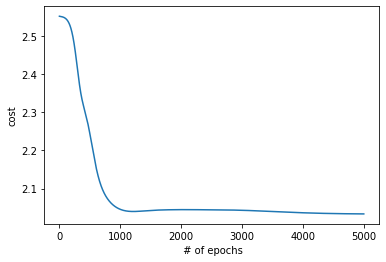

In [71]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128,
                                parameters=None, print_cost=True)

### Evaluating results

The input sentence was :

After the deduction of the cost of investing beating the stock market is a loser's game

In [73]:
X_test = npy.arange(vocab_size)
X_test = npy.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = npy.argsort(softmax_test, axis=0)[-4:,:]
top_sorted_inds

array([[ 6,  6,  9,  4,  1,  6,  2,  2,  4,  4,  6,  8,  2],
       [ 8,  8, 10,  3, 11,  2,  7,  6,  3,  6,  9,  3, 10],
       [ 3,  3,  5,  1,  8,  5,  4,  4,  1,  5, 12,  1,  9],
       [11, 11,  6,  0,  7,  9,  1,  9,  0, 11,  2,  0,  5]])

In [76]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbour words: {}".format(input_word, output_words))

game's neighbour words: ['is', "loser's", 'a', 'beating']
market's neighbour words: ['is', "loser's", 'a', 'beating']
cost's neighbour words: ['beating', 'of', 'deduction', 'the']
loser's's neighbour words: ['game', 'market', "loser's", 'stock']
stock's neighbour words: ['investing', 'a', 'is', 'market']
of's neighbour words: ['the', 'of', 'cost', 'beating']
beating's neighbour words: ['market', 'stock', 'investing', 'cost']
investing's neighbour words: ['the', 'stock', 'beating', 'cost']
a's neighbour words: ['game', 'market', "loser's", 'stock']
the's neighbour words: ['is', 'of', 'beating', 'stock']
deduction's neighbour words: ['cost', 'after', 'the', 'beating']
is's neighbour words: ['game', 'market', "loser's", 'a']
after's neighbour words: ['of', 'the', 'deduction', 'cost']
